In [1]:
%load_ext autoreload
%autoreload 2

import os
import gc
import time
import pickle
import numpy as np; np.random.seed(42)
import pandas as pd
from datetime import datetime
from sklearn.base import BaseEstimator
import lightgbm as lgb
import category_encoders as ce
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import (compute_scaling, compute_weights, reduce_mem_usage, 
                   compute_scales_by_level, compute_weights_by_level)
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12
from encoding import HierarchicalEncoder

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
logger = open(f"../logs/pipeline-level12-{datetime.now()}", "w")

***
# Input data

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )
data["sales"] = data.eval("y * sell_price")

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
weighting_input = pd.read_parquet("../input/weighting_input.parquet")

In [4]:
STORE_ID = 3 # CA_3

if STORE_ID is not None:
    data = data.query("store_id == @STORE_ID").reset_index(drop=True)
    
    if STORE_ID in [1,2,3,4]:
        data.drop(["snap_TX", "snap_WI", "snap_TX_cum", "snap_WI_cum"], axis=1, inplace=True)
    elif STORE_ID in [5,6,7]:
        data.drop(["snap_CA", "snap_WI", "snap_CA_cum", "snap_WI_cum"], axis=1, inplace=True)
    elif STORE_ID in [8,9,10]:
        data.drop(["snap_TX", "snap_CA", "snap_TX_cum", "snap_CA_cum"], axis=1, inplace=True)
    
    logger.write(f"\n- only store_id: {STORE_ID} \n\n")
    logger.flush()

***
# Models configuration

In [5]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':1000,
    'early_stopping_rounds':200,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 511,
    'min_data_in_leaf': 511,
    'learning_rate': 0.03, 
    'feature_fraction': 0.7,
    'bagging_fraction':0.9,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    #"year_week",
    #"year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    "year_week_cos",
    "year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "store_id",
    "state_id",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    
    "prev_newyear",
    "post_newyear",
    "prev_lw",
    "post_lw",
    "post_christmas",
    "post_thanksgiving",
    
    "no_stock_days",
    "sales",
]

if STORE_ID is not None:
    exclude_features.append("store_id")
    exclude_features.append("state_id")
    
categorical_features = {
    "item_id": ("y", ce.GLMMEncoder, None),
    "dept_id": "default",
    "cat_id": "default",
    "event_name_1": "default",}
if STORE_ID is None:
    categorical_features["store_id"] = "default"
    categorical_features["state_id"] = "default"

ts_uid_columns = ["item_id",]
if STORE_ID is None:
    ts_uid_columns.append("store_id")

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "window_shifts":[1,7,28,56],
    "window_functions":["mean","median","std","kurt",],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":categorical_features,
    "ts_uid_columns":ts_uid_columns
}

lagged_features = list()
if "lags" in model_kwargs.keys():
    lag_features = [f"lag{lag}" for lag in model_kwargs["lags"]]
    lagged_features.extend(lag_features)
if "window_functions" in model_kwargs.keys():
    rw_features = [f"{window_func}{window_size}_shift{window_shift}" 
                   for window_func in model_kwargs["window_functions"]
                   for window_size in model_kwargs["window_sizes"]
                   for window_shift in model_kwargs["window_shifts"]]
    lagged_features.extend(rw_features)
    
lagged_features_to_dropna = [feat for feat in lagged_features if feat not in ["skew", "kurt"]]

In [6]:
logger.write("#"*100+"\n")
logger.write(" MODEL CONFIGURATION ".center(100, "#")+"\n")
logger.write("#"*100+"\n\n")
logger.write(f"- model_params: \n{model_params}\n\n")
logger.write(f"- time_features: \n{model_kwargs['time_features']}\n\n")
if "lags" in model_kwargs.keys():
    logger.write(f"- lags: \n{model_kwargs['lags']}\n\n")
if "window_functions" in model_kwargs.keys():
    logger.write(f"- window_functions: \n{model_kwargs['window_functions']}\n\n")
if "window_shifts" in model_kwargs.keys():
    logger.write(f"- window_shifts: \n{model_kwargs['window_shifts']}\n\n")
if "window_sizes" in model_kwargs.keys():
    logger.write(f"- window_sizes: \n{model_kwargs['window_sizes']}\n\n")
logger.write(f"- categorical_features: \n{model_kwargs['categorical_features']}\n\n")
logger.flush()

***

In [7]:
valid_periods = [
    (pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
    (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
    (pd.to_datetime("2016-03-28"), pd.to_datetime("2016-04-24")),
    (pd.to_datetime("2016-04-25"), pd.to_datetime("2016-05-22")),
]

####################################################################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################


../lib/utils.py:68: RuntimeWarning:

Mean of empty slice



Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6095
[LightGBM] [Info] Number of data points in the train set: 2157843, number of used features: 62
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 1.69223	valid_0's wrmsseL12: 0.940595
[50]	valid_0's wrmsse: 0.975678	valid_0's wrmsseL12: 0.793843
[75]	valid_0's wrmsse: 0.665729	valid_0's wrmsseL12: 0.745543
[100]	valid_0's wrmsse: 0.567	valid_0's wrmsseL12: 0.731968
[125]	valid_0's wrmsse: 0.540198	valid_0's wrmsseL12: 0.728267
[150]	valid_0's wrmsse: 0.529486	valid_0's wrmsseL12: 0.726609
[175]	valid_0's wrmsse: 0.523061	valid_0's wrmsseL12: 0.72552
[200]	valid_0's wrmsse: 0.519806	valid_0's wrmsseL12: 0.724961
[225]	valid_0's wrmsse: 0.517506	valid_0's wrmsseL12: 0.724675
[25

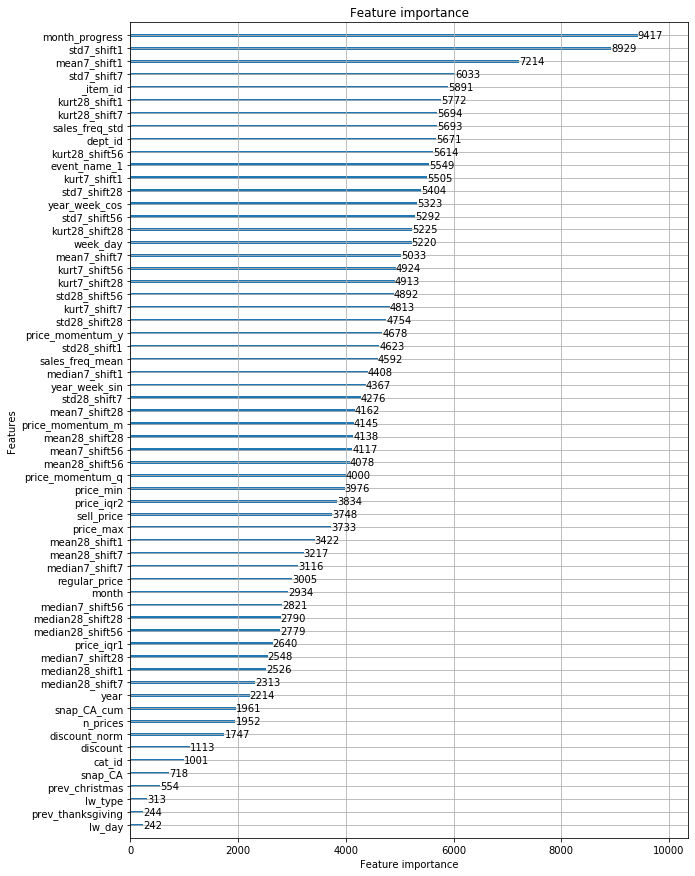

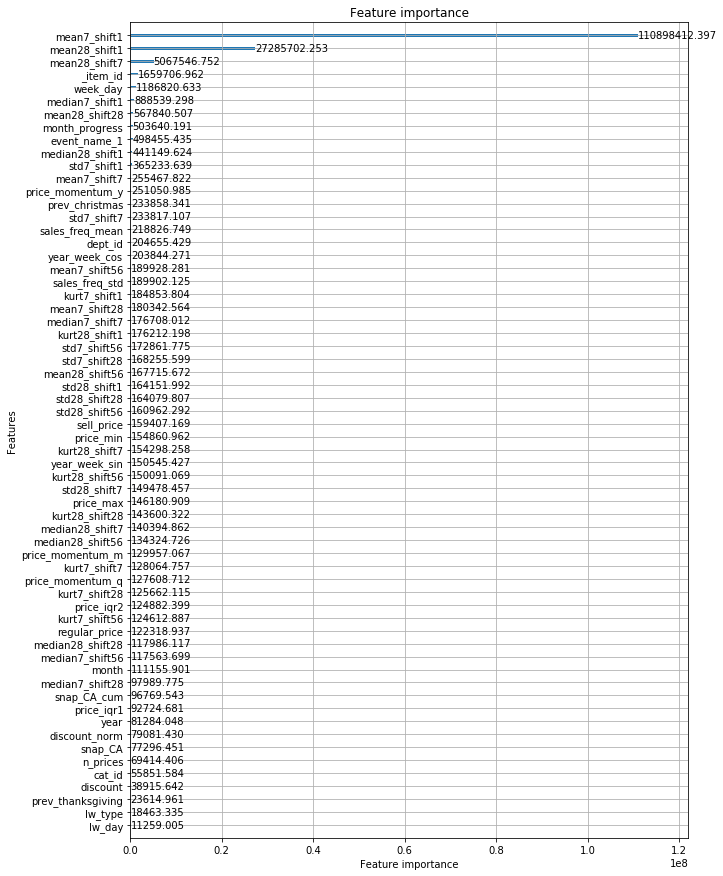

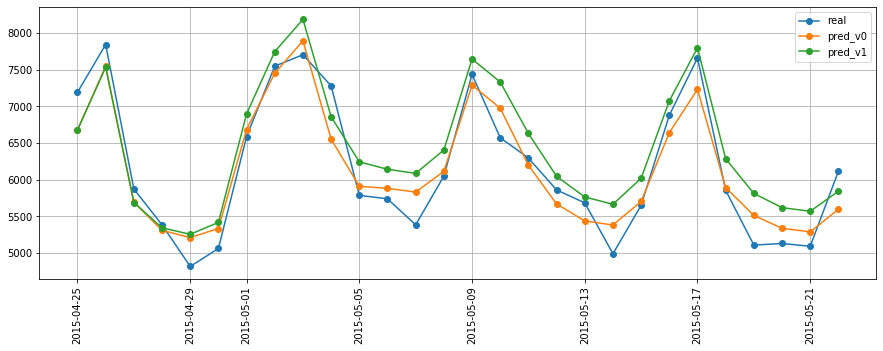

####################################################################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6095
[LightGBM] [Info] Number of data points in the train set: 2215618, number of used features: 62
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 1.85537	valid_0's wrmsseL12: 0.963597
[50]	valid_0's wrmsse: 1.11008	valid_0's wrmsseL12: 0.819252
[75]	valid_0's wrmsse: 0.797017	valid_0's wrmsseL12: 0.773951
[100]	valid_0's wrmsse: 0.68793	valid_0's wrmsseL12: 0.761499
[125]	valid_0

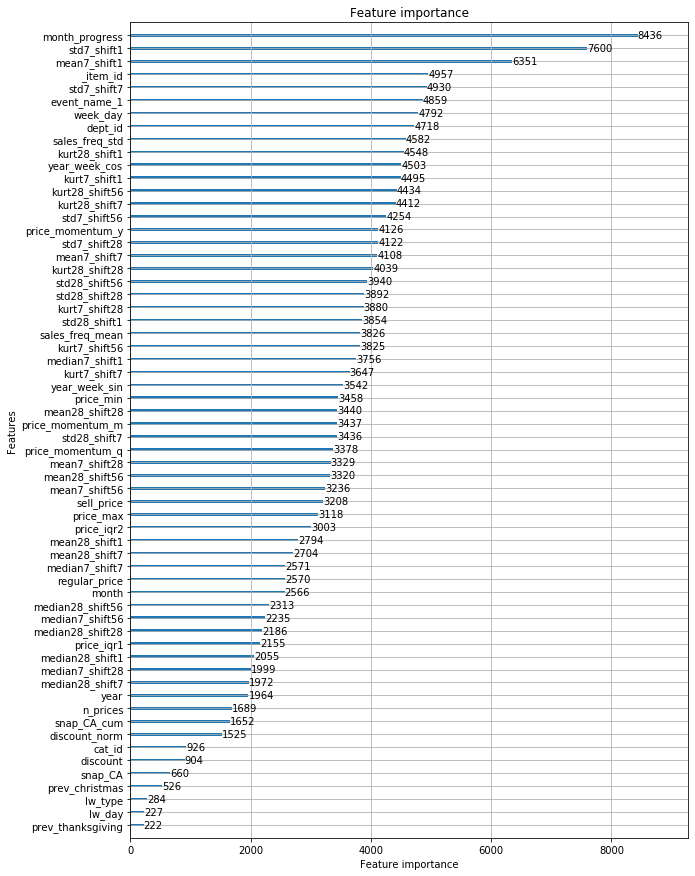

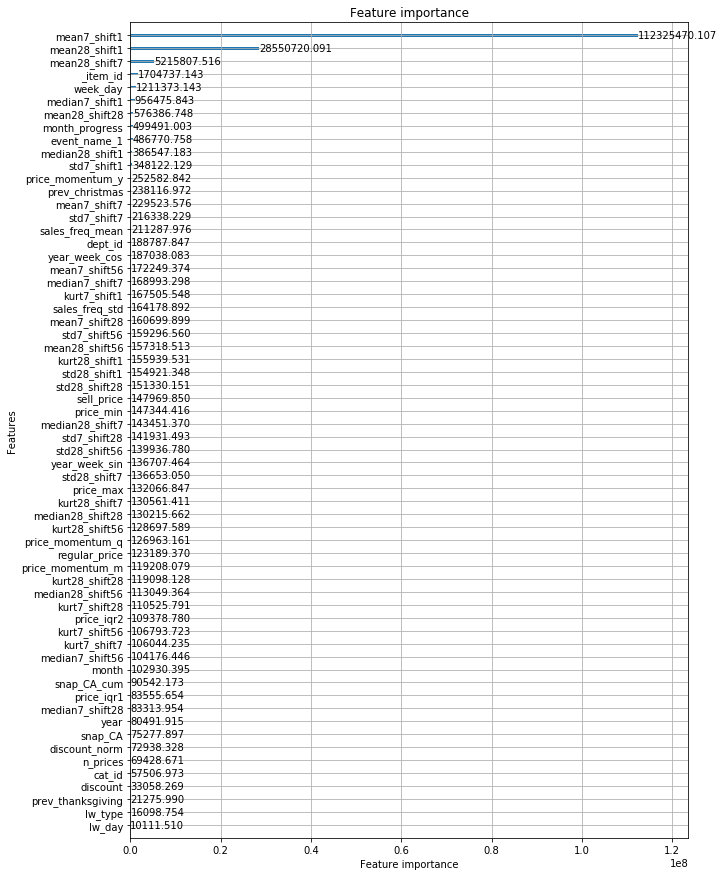

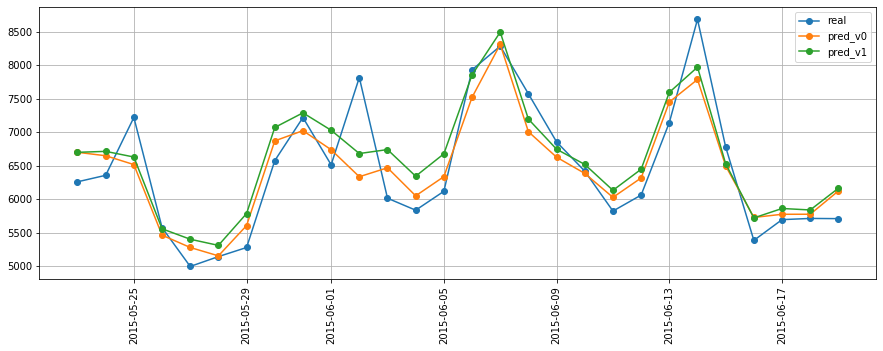

####################################################################################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.152248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6102
[LightGBM] [Info] Number of data points in the train set: 2856354, number of used features: 62
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 1.71431	valid_0's wrmsseL12: 0.967961
[50]	valid_0's wrmsse: 0.969832	valid_0's wrmsseL12: 0.826427
[75]	valid_0's wrmsse: 0.63634	valid_0's wrmsseL12: 0.782601
[100]	valid_0's wrmsse: 0.528422	valid_0's wrmsseL12: 0.77138
[125]	valid_0

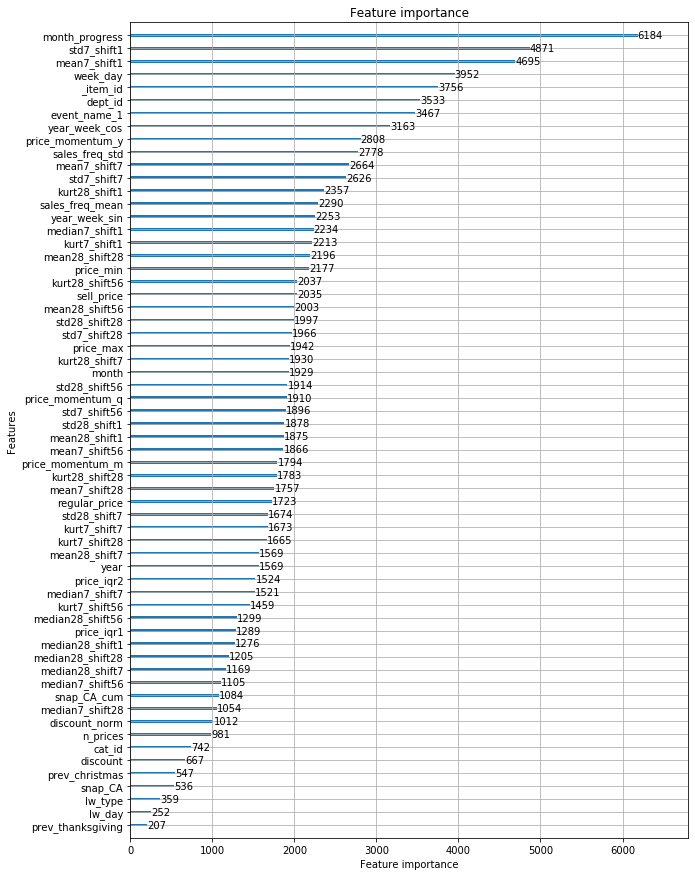

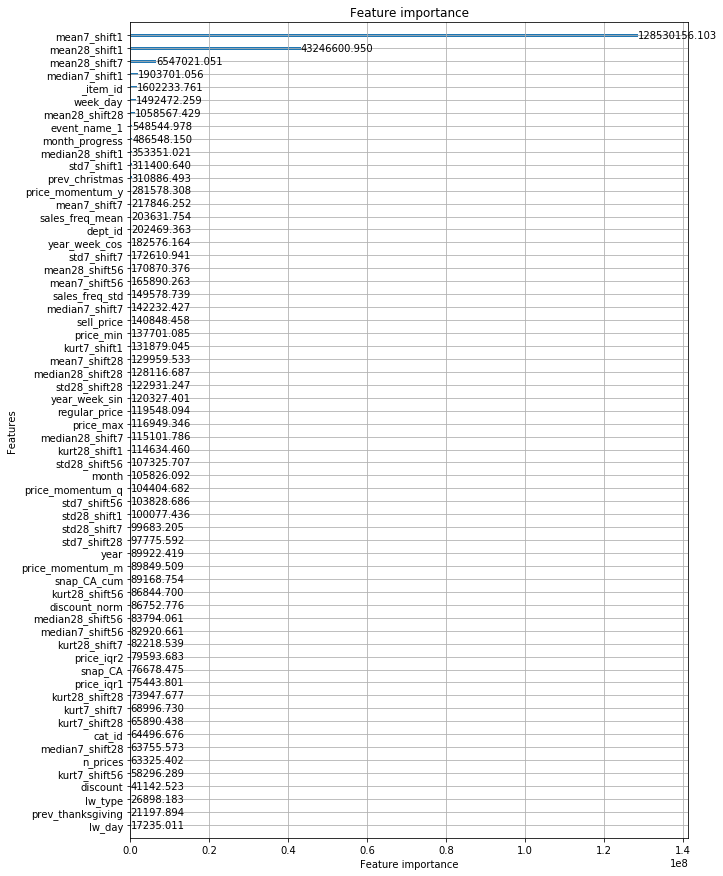

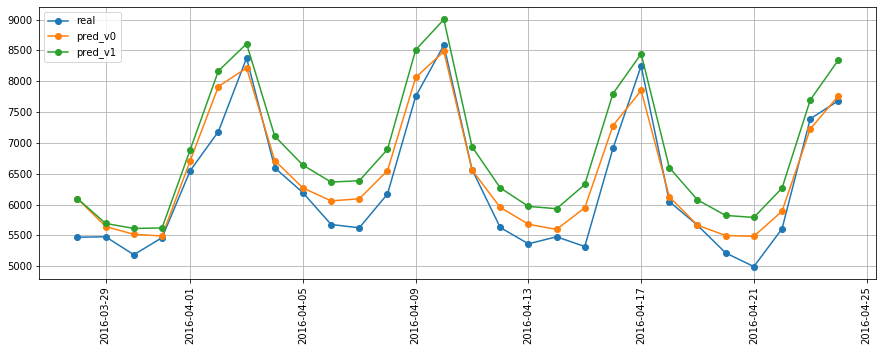

####################################################################################################
##### Validation period: (Timestamp('2016-04-25 00:00:00'), Timestamp('2016-05-22 00:00:00')) ######
####################################################################################################
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.141134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6101
[LightGBM] [Info] Number of data points in the train set: 2916486, number of used features: 62
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 1.60252	valid_0's wrmsseL12: 0.930031
[50]	valid_0's wrmsse: 0.897422	valid_0's wrmsseL12: 0.789937
[75]	valid_0's wrmsse: 0.591237	valid_0's wrmsseL12: 0.746913
[100]	valid_0's wrmsse: 0.493428	valid_0's wrmsseL12: 0.73656
[125]	valid_

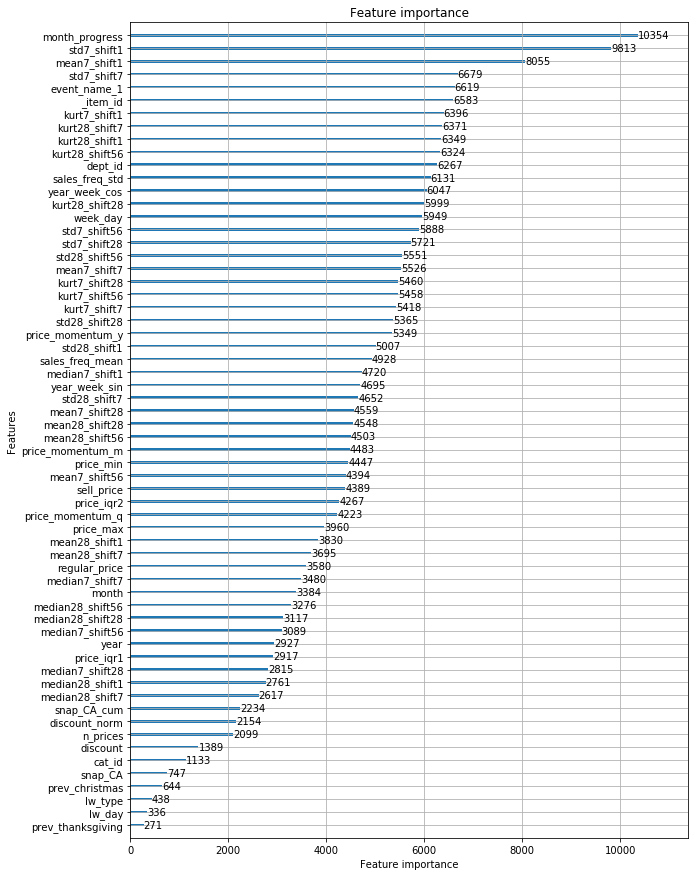

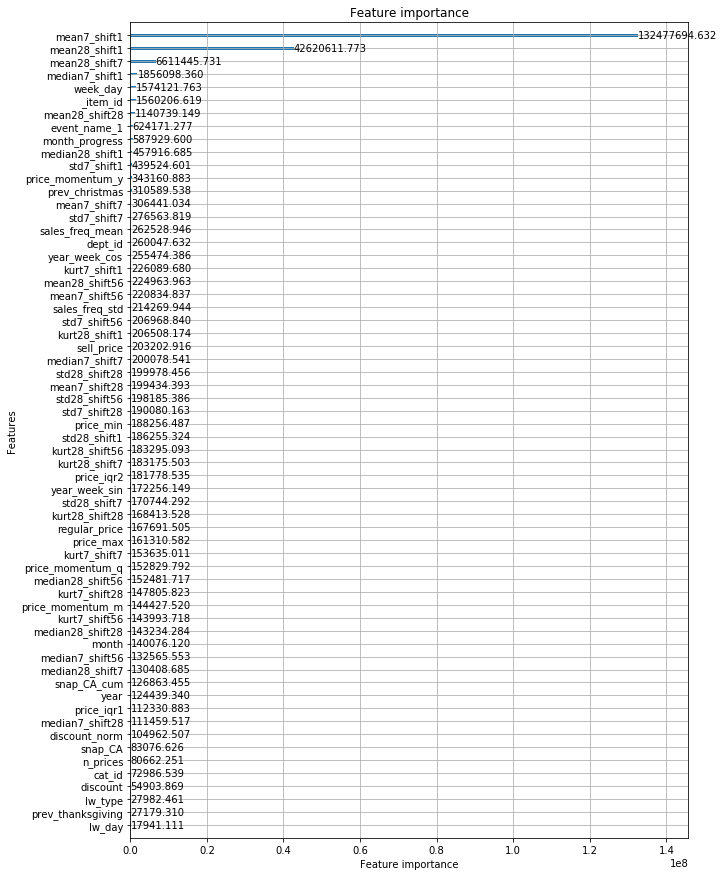

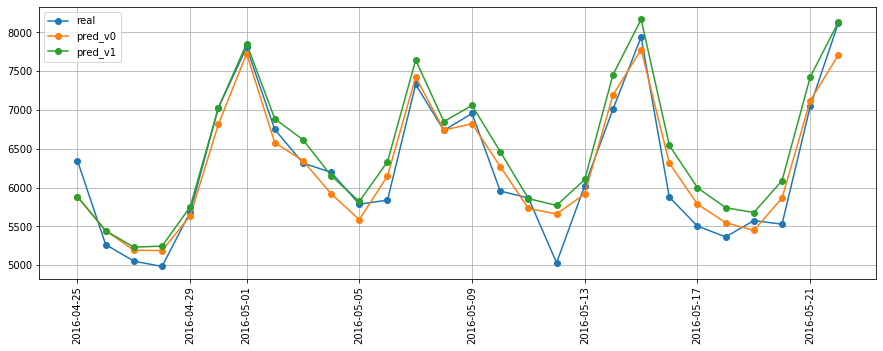

CPU times: user 5h 3min 31s, sys: 57min 48s, total: 6h 1min 20s
Wall time: 42min 11s


In [8]:
%%time
all_wrmsse_s1 = dict()
all_wrmsse_s2 = dict()
all_wrmsseL12_s1 = dict()
all_wrmsseL12_s2 = dict()

for i,valid_period in enumerate(valid_periods):

    print("#"*100)
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    logger.write("#"*100 + "\n")
    logger.write(f" Validation period: {valid_period} ".center(100, "#") + "\n")
    logger.write("#"*100 + "\n\n")

    valid_start = valid_period[0]
    valid_end = valid_period[1]
    _train_data = data.query("ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index
    
    scales_by_level = compute_scales_by_level(scaling_input, valid_start)
    weights_by_level = compute_weights_by_level(weighting_input, valid_start)
    scales_level12 = scales_by_level[12]
    weights_level12 = weights_by_level[12]
    
    model_level12 = LightGBMForecaster(**model_kwargs)
    model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index)
    model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
    
    model_level12.train_features = reduce_mem_usage(model_level12.train_features)
    model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
    
    ts_id_in_train = model_level12.train_features.ts_id.unique()
    model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")

    logger.write(f"- training samples: {len(model_level12.train_features)} \n\n")
    logger.write(f"- validation samples: {len(model_level12.valid_features)} \n\n")
    logger.write(f"- ts in train set: {model_level12.train_features.ts_id.nunique()} \n\n")
    logger.write(f"- ts in valid set: {model_level12.valid_features.ts_id.nunique()} \n\n")
    logger.write(f"- input_features: {model_level12.input_features} \n\n")
    logger.flush()
    
    print("Fitting the model")
    tic = time.time()
    evaluator = Evaluator(model_level12.valid_features, weights_by_level, scales_by_level, single_store=True)
    model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")
    
    logger.write(f"- best_iteration: {model_level12.best_iteration} \n\n")
    logger.flush()

    lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,15))
    lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,15))

    print("Predicting with ground thruth lagged values")
    tic = time.time()
    forecast_v0 = (model_level12.valid_features
                   .loc[:, ["ds"]+model_level12.ts_uid_columns]
                   .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")
    
    wrmsse = evaluator.eval1._evaluate(forecast_v0.y_pred.values)
    wrmsseL12 = evaluator.eval2._evaluate(forecast_v0.y_pred.values)
    errors_by_level = evaluator.eval1.errors_by_level
    
    all_wrmsse_s1[f"f{i}"] = wrmsse
    all_wrmsseL12_s1[f"f{i}"] = wrmsseL12
    print("wrmsse:", wrmsse)
    print(errors_by_level)
    print("\n")
    
    logger.write(f"- wrmsse approach 1: {wrmsse} \n\n")
    logger.flush()

    print("Predicting with recursive approach")
    tic = time.time()
    valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
    forecast_v1 = model_level12.predict(valid_data, recursive=True)
    tac = time.time()
    print(f"Elapsed time: {(tac-tic)/60.} [min]")
    
    wrmsse = evaluator.eval1._evaluate(forecast_v1.y_pred.values)
    wrmsseL12 = evaluator.eval2._evaluate(forecast_v1.y_pred.values)
    errors_by_level = evaluator.eval1.errors_by_level
    
    all_wrmsse_s2[f"f{i}"] = wrmsse
    all_wrmsseL12_s2[f"f{i}"] = wrmsseL12
    print("wrmsse:", wrmsse)
    print(errors_by_level)
    print("\n")
    
    logger.write(f"- wrmsse approach 2: {wrmsse} \n\n")
    logger.flush()
    
    mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
           .merge(forecast_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
           .merge(forecast_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
    plt.figure(figsize=(15,5))
    plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
    plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
    plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
    plt.grid()
    plt.xticks(rotation=90)
    plt.legend(loc="best")
    plt.show()
    
    del model_level12, _train_data, _valid_index, evaluator
    gc.collect()

***

In [13]:
approach1 = list(errors_v0.values())
approach2 = list(errors_v1.values())

logger.write("#"*100 + "\n")
logger.write(f" Overall ".center(100, "#") + "\n")
logger.write("#"*100 + "\n\n")

logger.write(f"- approach 1 on all folds: {approach1} - mean: {np.mean(approach1)} \n\n")
logger.write(f"- approach 2 on all folds: {approach2} - mean: {np.mean(approach2)} \n\n")
logger.flush()

In [14]:
print(f"- approach 1 on all folds: {approach1} - mean: {np.mean(approach1)}")
print(f"- approach 2 on all folds: {approach2} - mean: {np.mean(approach2)}")

- approach 1 on all folds: [0.7240951776556215, 0.7506271096225061, 0.7668847361102306, 0.7317298391950027] - mean: 0.7433342156458402
- approach 2 on all folds: [0.7522745255291945, 0.7984572714483242, 0.8061342421799952, 0.7621771947421665] - mean: 0.7797608084749201


***